# Variational quantum eigensolving

Here, we generate a random Hamiltonian and use a simple ansatz to approximate its ground state energy by the Variational Quantum Eigensolver (VQE) method.

## Defining the Hamiltonian

Here, we define a random Hamiltonian with 5 terms acting on 3 qubits. In myQLM, Hamiltonians are implemented with ``Observable`` objects (https://myqlm.github.io/qat-core.html#module-qat.core.wrappers.observable).

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from qat.core import Observable, Term

def make_random_hamiltonian(nqbits, nterms):
    terms = []
    for _ in range(nterms):
        coeff = np.random.random()
        ops = "".join(np.random.choice(["X", "Z"], size=nqbits))
        qbits = np.random.choice(nqbits, size=nqbits, replace=False)
        terms.append(Term(coefficient=coeff, pauli_op=ops, qbits=qbits))
    hamiltonian = Observable(nqbits, pauli_terms=terms)
    return hamiltonian


nqbits = 3
nterms = 5
np.random.seed(1423543) #fixing seed to have reproducible results
hamiltonian = make_random_hamiltonian(nqbits, nterms)
print("H:", hamiltonian)

H: 0.5349858976103307 * (ZZZ|[2, 1, 0]) +
0.6223001690189702 * (ZXZ|[0, 1, 2]) +
0.2940544814678502 * (ZXZ|[2, 0, 1]) +
0.37366693739787715 * (XXX|[2, 0, 1]) +
0.3862787171234443 * (XZX|[2, 1, 0])


## Constructing a variational circuit

In the cell below, we construct a variational circuit, with $2 n_\mathrm{qbits}$ parameters $\vec{\theta}$. We choose only $R_y(\theta)$ rotations because we know the ground state to have only real amplitudes.

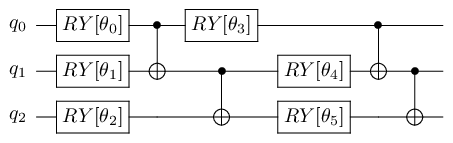

In [2]:
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ

def make_ansatz(use_cnots):
    # function that prepares an ansatz circuit
    
    prog = Program()
    reg = prog.qalloc(nqbits)
    theta = [prog.new_var(float, '\\theta_%s'%i)
             for i in range(nqbits * 2)]
    for ind in range(nqbits):
        RY(theta[ind])(reg[ind])
    if use_cnots:   
        for qb in range(nqbits-1):
            CNOT(reg[qb], reg[(qb+1)%nqbits])
    for ind in range(nqbits, 2*nqbits):
        RY(theta[ind])(reg[ind - nqbits])
    if use_cnots:   
        for qb in range(nqbits-1):
            CNOT(reg[qb], reg[(qb+1)%nqbits])
    
    circ = prog.to_circ()
    
    return circ

circ = make_ansatz(use_cnots=True)
%qatdisplay circ

This ansatz circuit produces an entangled state thanks to the CNOT gates.

## Creating a variational job and a variational stack

We now create a variational job from this circuit and observable.
It is then submitted to a variational stack composed of a perfect QPU, ``LinAlg``, and a variational plugin, ``ScipyMinimizePlugin``. The latter handles parametric jobs. These are jobs whose circuit contains a parameter that is then going to be optimized, using classical optimizers, so as to minimize the value of the observable over the final state.

Below, we are going to test three different classical optimizers: COBYLA, Nelder-Mead, and BFGS.

In [3]:
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin

circ = make_ansatz(use_cnots=True)
job = circ.to_job(job_type="OBS",
                  observable=hamiltonian,
                  nbshots=10000) # this is quite large. Try also nbshots=0

theta_0 = np.random.random(size=nqbits*2)

from qat.plugins import SPSAMinimizePlugin
linalg_qpu = get_default_qpu()
methods = ["COBYLA", "Nelder-Mead", "BFGS", "SPSA"]
result = {}
for method in methods:
    if method == "SPSA":
        optimizer = SPSAMinimizePlugin(x0=theta_0) 
    else:
        optimizer = ScipyMinimizePlugin(method=method,
                                        tol=1e-6,
                                        options={"maxiter": 200},
                                        x0=theta_0)
    qpu = optimizer | linalg_qpu
    result[method] = qpu.submit(job)

    print("Minimum VQE energy (%s) = %s"%(method, result[method].value))

Minimum VQE energy (COBYLA) = -1.5375038013840339
Minimum VQE energy (Nelder-Mead) = -0.4532083164585752
Minimum VQE energy (BFGS) = 0.24200779595652494
Minimum VQE energy (SPSA) = -0.8145004257569803


One can check that the final optimized energy is not so close to the exact GS energy... but what happens when use_cnots=True?

## Plotting the results

Let us now plot the value of the variational energy over the course of the classical optimization. For this, we can retrieve information about the variational job execution in the ``meta_data`` field of the result.

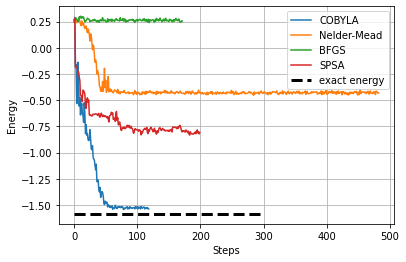

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
for method in methods:
    plt.plot(eval(result[method].meta_data['optimization_trace']),
             label=method)
    
from utils_tuto import make_matrix
H_mat = make_matrix(hamiltonian)
eigvals = np.linalg.eigvalsh(H_mat)
E0 = min(eigvals)

plt.plot([E0 for _ in range(300)], '--k', lw=3, label="exact energy")
    
plt.grid()
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy");

We can see that COBYLA & SPSA converge faster than the other two methods.

### With a noisy QPU

In [6]:
import time
from depolarizing_plugin import DepolarizingPlugin
depol_plugin = DepolarizingPlugin(prob_1qb=0.005, prob_2qb=0.05)
qpu = get_default_qpu()
noisy_qpu = depol_plugin | qpu

method = "COBYLA"
optimizer = ScipyMinimizePlugin(method=method,
                                tol=1e-6,
                                options={"maxiter": 200},
                                x0=theta_0)
qpu = optimizer | noisy_qpu
st = time.time()
result[method+"-noisy"] = qpu.submit(job)

print("Minimum VQE energy (%s) = %s [%s seconds]"%(method, result[method].value, time.time() - st))

Minimum VQE energy (COBYLA) = -1.5375038013840339 [501.07421612739563 seconds]


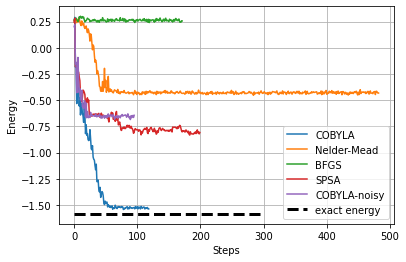

In [7]:
for method in result.keys():
    plt.plot(eval(result[method].meta_data['optimization_trace']),
             label=method)
    
from utils_tuto import make_matrix
H_mat = make_matrix(hamiltonian)
eigvals = np.linalg.eigvalsh(H_mat)
E0 = min(eigvals)

plt.plot([E0 for _ in range(300)], '--k', lw=3, label="exact energy")
    
plt.grid()
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy");